# Data Exploration
<hr>
The purpose of this notebook is to accomplish the following goals:
<ul>
<li>Plot the distribution of app sizes across our three categories. This column is called Size_Bytes in the App Store data and Size in the Google Play data.
</li>
<li>Compute the average rating across all ratings for each of the three categories. Note that we’re not looking for an average of the average ratings for each category, but rather the average across all ratings for each category. For example, if we have two apps in the same category and one app has 1 rating with an average of 1.0 and the other app has 2 ratings with an average of 5.0, the value we’re looking for is 3.7 (average of 1, 5, and 5), not 3.0 (average of 1 and 5). The relevant columns here are Average_User_Rating and Reviews for the App Store and Rating and Rating Count for Google Play.
</li>
<li>Plot the number of new releases in each category over time by month, using the Released column.</li>
<li>List the 10 biggest apps by size in each category by year.</li>
</ul>

In [40]:
import pandas as pd
from sqlalchemy import create_engine
from queries import and_query_cleaned, apl_cleaned_query
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
from operator import itemgetter
import numpy as np

In [2]:
engine = create_engine('postgresql://postgres:postgres@db:5432/postgres')
apl_df = pd.read_sql(apl_cleaned_query,engine)
and_df = pd.read_sql(and_query_cleaned,engine)

## Initial Setup
Some data needs to be cleaned prior to knocking out all the points above. This includes modifying some dates and converting android's data for size to bytes.

We can also create genre-based sub-dataframes since many of the questions require the data to be broken up based on genre.

In [3]:
datetimes = []
for i in list(apl_df['release_date']):
    try:
        datetimes.append(datetime.strptime(i[:10], '%Y-%m-%d'))
    except:
        datetimes.append(i)

In [4]:
apl_df['release_date'] = datetimes

In [5]:
datetimes = []
for i in list(and_df['release_date']):
    datetimes.append(datetime.strptime(i, '%b %d, %Y'))

In [6]:
and_df['release_date'] = datetimes

In [10]:
# establishing filesizes
kb = 1000
mb = 1000 * kb
gb = 1000 * mb

In [11]:
# computing filesizes based on the last letter in the str
# M = MB, e = Varies with device (set to none)
# k = kb, G = GB
calc = []
for i in list(and_df['filesize']):
    if i[-1] == 'M':
        calc.append(float(i[:-1].replace(',','')) * mb)
    elif i[-1] == 'k':
        calc.append(float(i[:-1].replace(',','')) * kb)
    elif i[-1] == 'G':
        calc.append(float(i[:-1].replace(',','')) * gb)
    else:
        calc.append(None)

In [12]:
and_df['filesize'] = calc

In [13]:
df = pd.concat([apl_df,and_df])

In [15]:
sub_health = df.loc[df['genre'] == 'Health & Fitness']
sub_games = df.loc[df['genre'] == 'Games']
sub_music = df.loc[df['genre'] == 'Music']

## Task 1/4
> Plot the distribution of app sizes across our three categories. This column is called Size_Bytes in the App Store data and Size in the Google Play data.

I renamed the columns to be able to concat the data easier and because the new names made more sense, so keep note of that.

In [17]:
#get average file size, divided by mb
avgfs_health = sub_health['filesize'].mean() / mb
avgfs_games = sub_games['filesize'].mean() / mb
avgfs_music = sub_music['filesize'].mean() / mb

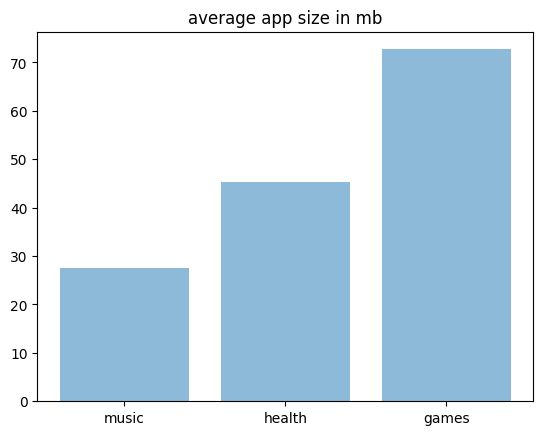

In [20]:
x = ['music','health','games']
y = [avgfs_music,avgfs_health,avgfs_games]

plt.bar(x, y, align='center', alpha=0.5)

plt.title('average app size in mb')
plt.show()

## Task 2/4
> Compute the average rating across all ratings for each of the three categories. Note that we’re not looking for an average of the average ratings for each category, but rather the average across all ratings for each category. For example, if we have two apps in the same category and one app has 1 rating with an average of 1.0 and the other app has 2 ratings with an average of 5.0, the value we’re looking for is 3.7 (average of 1, 5, and 5), not 3.0 (average of 1 and 5). The relevant columns here are Average_User_Rating and Reviews for the App Store and Rating and Rating Count for Google Play.

This one was pretty straight forward. I opted to print instead of return vals because it involved less copy-paste so it looked cleaner.

In [29]:
def print_rate(sub_df):
    # gets the rating, and the amount of times its been rated
    rate = list(sub_df['rating'])
    amt = list(sub_df['rating_amt'])

    combined_rates = list(zip(rate, amt))

    # .5 avoids nulls and apps with no ratings
    ratings = 0
    combined_score = 0
    for i in combined_rates:
        if i[1] > .5:
            combined_score = combined_score + (i[0] * i[1])
            ratings = ratings + i[1]

    print("   Average rating:",combined_score / ratings)
    print("   Total ratings: ",int(ratings))

In [31]:
print("Health")
print_rate(sub_health)
print("Music")
print_rate(sub_music)
print("Games")
print_rate(sub_games)

Health
   Average rating: 4.5555467914962655
   Total ratings:  107669523
Music
   Average rating: 4.479038125325136
   Total ratings:  219415045
Games
   Average rating: 4.311394363825693
   Total ratings:  3006884828


## Task 3/4
> Plot the number of new releases in each category over time by month, using the Released column.

I apologize in advance for the ugly graph, I'm not an analyst or front-end guy.

In [33]:
# returns dict of counts per month
# and a unique list of all dates
def get_count_dicts(sub_df):
    years = []
    months = []
    for i in list(sub_df['release_date']):
        years.append(i.year)
        months.append(i.month)

    data = list(zip(years, months))
    counted = dict(Counter(data))
    unq = list(set(data))
    return counted,unq

In [34]:
counted_health,unq_health = get_count_dicts(sub_health)
counted_games,unq_games = get_count_dicts(sub_games)
counted_music,unq_music = get_count_dicts(sub_music)

In [36]:
# combining all of them because they dont all
# have the same amount of dates
combined = unq_health + unq_games + unq_music
unq_combined = list(set(combined))

# one of the categories had null dates, so using
# this to remove it so itll properly sort
nullremoved = []
for i in unq_combined:
    if type(i[0]) != float:
        nullremoved.append(i)

In [37]:
sorteddate = sorted(
    nullremoved, 
    key=lambda x: x[1]
)

sorteddate = sorted(
    sorteddate, 
    key=lambda x: x[0]
)

In [38]:
# this uses a lot of try-catches because I 
# didnt import default dicts and im too far in
# to go back now...

x = []
y = []
y2 = []
y3 = []
for i in sorteddate:
    x.append(str(i[1]) + "/" + str(i[0]))
    try:
        y.append(counted_games[i])
    except:
        y.append(0)
    try:
        y2.append(counted_health[i])
    except:
        y2.append(0)
    try:
        y3.append(counted_music[i])
    except:
        y3.append(0)

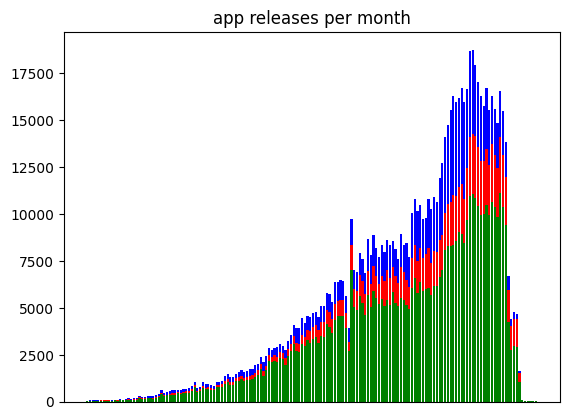

In [41]:
fig, ax = plt.subplots()

# Stacked bar chart
ax.bar(x, y, color = "green") #games
ax.bar(x, y2, bottom = y, color = "red") #health
ax.bar(x, y3, bottom = np.add(y, y2), color = "blue") #music

plt.xticks([])
plt.title('app releases per month')
plt.show()

## Task 4/4
> List the 10 biggest apps by size in each category by year.

I was a little bit suspicious because all the top results were ios apps, but I confirmed my conversion math was right, and compared some of the largest total Android apps just to double check.

All of the hand-picked large Android apps were way smaller than apple apps of the same year, so I think this list is correct.

In [44]:
df = df.sort_values(by='filesize', ascending=False)

In [46]:
grouped = df.groupby(['genre', 'release_year']).head(10)

In [48]:
grouped = grouped.sort_values(['genre', 'release_year'])

In [50]:
# this is a little large so it would be awkward to display in
# a notebook, BUT since this was the last objective and this
# is the final cell, im gonna do it anyway
pd.set_option('display.max_rows', 500)
grouped

,name,release_date,release_year,filesize,genre,rating,rating_amt,platform
10067,QBeez,2008-11-24,2008,2.657260e+08,Games,3.36585,41.0,apple
9822,PAC-MAN,2008-10-18,2008,2.207160e+08,Games,4.18804,21813.0,apple
41090,Kroll,2008-09-29,2008,2.106672e+08,Games,3.54545,33.0,apple
91934,Solitaire Classic ©,2008-11-08,2008,1.804339e+08,Games,3.50000,4.0,apple
90793,Soccer Physics - free online foosball skill fr...,2008-12-03,2008,1.573775e+08,Games,2.60000,5.0,apple
71606,Checkers ・,2008-10-29,2008,1.245358e+08,Games,4.46382,38892.0,apple
9693,Backgammon - Classic Dice Game,2008-12-16,2008,1.205422e+08,Games,4.35913,11358.0,apple
276250,Crazy Snowboard,2008-10-30,2008,1.036749e+08,Games,4.48837,43.0,apple
110476,Deep Green Chess,2008-12-09,2008,9.915699e+07,Games,4.07692,26.0,apple
122898,Iron Fist Boxing,2008-12-24,2008,9.844531e+07,Games,1.00000,3.0,apple
